__author__ = 'Armando Collado-Villaverde'  
__email__ = 'armando.collado@uah.es'

# SUPERPOSED EPOCH ANALYSIS FOR THE SYM-H STORMS OF EACH INTENSITY CLASS
Contains the superposed epoch analysis for the SYM and ASY indices, the storms are selected and classified based on the thresholds calculated on the previous notebook and 5 days are selected before and after the peak value of each storm. Then, storms from the same class are averaged using the peak value of the index as the 0 epoch.  

* [SYM-H STORMS](#section_1)
* [SUPERPOSED PLOTS](#section_2)
  * [Forward](#section_2_1)
  * [Backward](#section_2_2)
  * [Both directions](#section_2_3)
  * [PELT analysis](#section_2_4)

In [1]:
import pandas as pd
import utils
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ruptures as rpt

# Set seaborn styles for the plots
sns.set_style('whitegrid')
sns.set_context("paper")

In [2]:
print('Finding storms based on the findings of the distribution of the minimum of the SYM-H index when grouping in 27 days to avoid persistence\n')

# Print threshold information for classification
print(f'Times when the SYM-H is over {utils.SYM_H_THRESHOLD_LOW} (percentile 40) will be ignored')
print(f'Times when the SYM-H is between {utils.SYM_H_THRESHOLD_LOW} and {utils.SYM_H_THRESHOLD_MODERATE} (percentile 20) will be classified as "LOW"')
print(f'Times when the SYM-H is between {utils.SYM_H_THRESHOLD_MODERATE} and {utils.SYM_H_THRESHOLD_INTENSE} (percentile 5) will be classified as "MODERATE"')
print(f'Times when the SYM-H is between {utils.SYM_H_THRESHOLD_INTENSE} and {utils.SYM_H_THRESHOLD_SUPERINTENSE} (percentile 1) will be classified as "INTENSE"')
print(f'Times when the SYM-H is below {utils.SYM_H_THRESHOLD_SUPERINTENSE} will be classified as "SUPERINTENSE"')

Finding storms based on the findings of the distribution of the minimum of the SYM-H index when grouping in 27 days to avoid persistence

Times when the SYM-H is over -90 (percentile 40) will be ignored
Times when the SYM-H is between -90 and -130 (percentile 20) will be classified as "LOW"
Times when the SYM-H is between -130 and -230 (percentile 5) will be classified as "MODERATE"
Times when the SYM-H is between -230 and -390 (percentile 1) will be classified as "INTENSE"
Times when the SYM-H is below -390 will be classified as "SUPERINTENSE"


In [3]:
# Read data from pickle file
dfx = pd.read_pickle('./data/sym_asy_indices.pkl', compression='gzip')

## SYM-H STORMS <a class="anchor" id="section_1"></a>

In [4]:
# Extract dates with SYM-H index values below or equal to the low threshold
dates_sym = dfx['SYM_H'].reset_index().copy()
dates_sym = dates_sym.loc[dates_sym['SYM_H'] <= utils.SYM_H_THRESHOLD_LOW]

# Set the last valid year for storm classification
last_valid_year = 2022

# Initialize empty list to store storm data
storms_sym = []

Iterate over the dates with SYM-H values of low intensity.

* Calculate the start and end dates for the storm period based on the current date using one day as the offset.
* Find the minimum SYM-H value within the storm period.
* Find the index of the storm center (first occurrence of the minimum SYM-H value).
* Calculates the extended start and end dates for the storm period, considering 5 additional days before and after for the superposed epoch analysis.
* Checks if the end date exceeds the last valid year for classification and skips the current date if it does.
* Extracts the storm data within the extended period.
* Checks if there are more storms within the extended period with lower SYM-H values and updates the storm data accordingly.
* Checks if the new storm period overlaps with the previous storm and merges them if it does.
* Adds the new storm data to the list.

In [5]:
# Iterate over the dates with low SYM_H values
for i in range(len(dates_sym)):
    # Minimum days around the date to find the minimum
    st = dates_sym.iloc[i]['datetime'] - utils.MINIMUM_DAYS_BEFORE
    nd = dates_sym.iloc[i]['datetime'] + utils.MINIMUM_DAYS_AFTER
    
    # Find the minimum SYM_H value within the storm period
    storm_min = dfx[st:nd]['SYM_H'].min()    
    
    # Find the index of the storm center (first occurrence of the minimum SYM_H value)
    storm_center = dfx[st:nd].loc[dfx[st:nd]['SYM_H'] == storm_min].first_valid_index()    
    
    # Calculate the start and end dates for the storm period to include additional days for analysis
    newst = storm_center - utils.SUPERPOSED_OFFSET_DAYS_BEFORE
    newst = newst.floor('D')
    newnd = storm_center + utils.SUPERPOSED_OFFSET_DAYS_AFTER
    newnd = newnd.ceil('D')
    
    # Check if the end date exceeds the last valid year for classification, and skip if it does
    if (newnd.year > last_valid_year):
        continue
    
    # Extract the storm data within the new period
    new_df = dfx[newst:newnd].copy()

    # Check if there are more storms within the new period with lower SYM_H values
    while new_df['SYM_H'].min() < storm_min:
        # Update the storm center and end date based on the new minimum SYM_H value
        storm_center = dfx[newst:newnd].loc[dfx[newst:newnd]['SYM_H'] == storm_min].last_valid_index()        
        newnd = storm_center + utils.SUPERPOSED_OFFSET_DAYS_AFTER
        newnd = newnd.ceil('D')
        
        # Update the storm data within the new period
        new_df = dfx[newst:newnd].copy()
        storm_min = new_df[newst:newnd]['SYM_H'].min()
    
    # Check if the new storm period overlaps with the previous storm, and merge if it does
    if (len(storms_sym) >= 1):
        if storms_sym[-1].index[-1] >= newst:
            storms_sym[-1] = pd.concat([storms_sym[-1], new_df])
            storms_sym[-1] = storms_sym[-1].drop_duplicates(keep='first').sort_index()
            continue
            
    # Add the new storm data to the list
    storms_sym.append(new_df)

In [6]:
print(f"Total storms: {len(storms_sym)}")

Total storms: 252


In [7]:
# Create a summary dataframe with the start and end dates, the duration, the minimum SYM-H value 
# of the storm and the corresponding class of the storm
summary_df_sym = utils.get_summary_df_sym(storms_sym)
summary_df_sym['classification'] = 'LOW'
summary_df_sym.loc[(summary_df_sym['Min SYM-H'] <= utils.SYM_H_THRESHOLD_MODERATE) & (summary_df_sym['Min SYM-H'] > utils.SYM_H_THRESHOLD_INTENSE), 'classification'] = 'MODERATE'
summary_df_sym.loc[(summary_df_sym['Min SYM-H'] <= utils.SYM_H_THRESHOLD_INTENSE) & (summary_df_sym['Min SYM-H'] > utils.SYM_H_THRESHOLD_SUPERINTENSE), 'classification'] = 'INTENSE'
summary_df_sym.loc[summary_df_sym['Min SYM-H'] <= utils.SYM_H_THRESHOLD_SUPERINTENSE, 'classification'] = 'SUPERINTENSE'

All the storms

In [8]:
with pd.option_context('display.max_rows', 500, 'display.max_columns', 20):
    display(summary_df_sym) 

,Start date,End date,TD,Min SYM-H,classification
0,1981-02-02,1981-02-12 22:20:00,10 days 22:20:00,-153,MODERATE
1,1981-02-28,1981-03-19 23:35:00,19 days 23:35:00,-235,INTENSE
2,1981-04-08,1981-05-02 23:20:00,24 days 23:20:00,-338,INTENSE
3,1981-05-04,1981-05-23 23:55:00,19 days 23:55:00,-140,MODERATE
4,1981-06-24,1981-07-05 00:00:00,11 days 00:00:00,-95,LOW
5,1981-07-18,1981-07-31 23:50:00,13 days 23:50:00,-255,INTENSE
6,1981-08-18,1981-08-29 00:00:00,11 days 00:00:00,-116,LOW
7,1981-10-06,1981-10-27 23:45:00,21 days 23:45:00,-215,MODERATE
8,1981-11-07,1981-11-18 00:00:00,11 days 00:00:00,-132,MODERATE
9,1982-01-26,1982-02-10 23:40:00,15 days 23:40:00,-118,LOW


classification
LOW             137
MODERATE         86
INTENSE          22
SUPERINTENSE      7
Name: count, dtype: int64
Total number of storms: 252


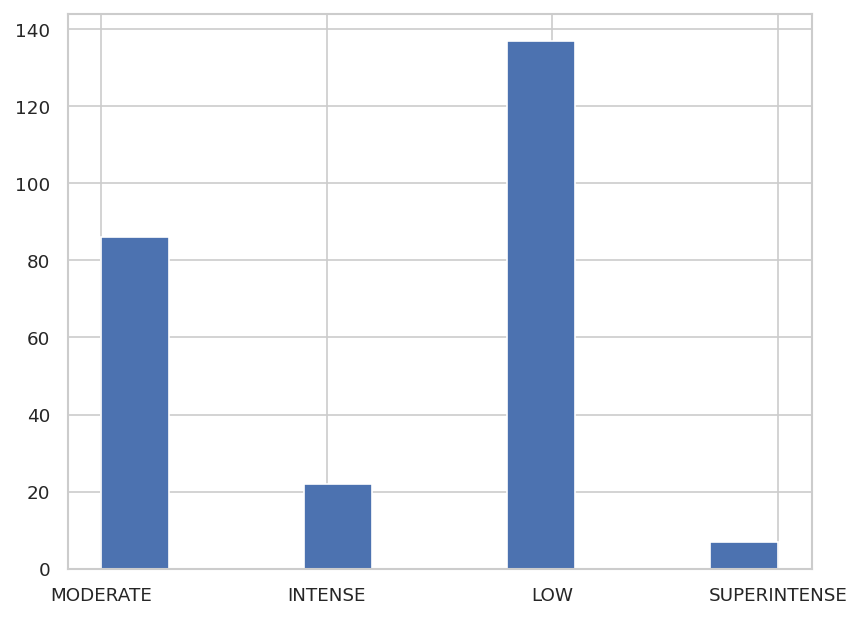

In [9]:
# Plot a histogram of the storm classifications
plt.hist(summary_df_sym['classification'], align='mid')
# Print the count of each storm classification
print(summary_df_sym['classification'].value_counts())
# Print the total number of storms
print('Total number of storms:', len(summary_df_sym))

In [10]:
# Get the indices of storms classified as 'LOW'
low_indices = summary_df_sym.loc[(summary_df_sym['Min SYM-H'] < utils.SYM_H_THRESHOLD_LOW) & 
                                 ((summary_df_sym['Min SYM-H'] > utils.SYM_H_THRESHOLD_MODERATE))].index

# Get the indices of storms classified as 'MODERATE'
moderate_indices = summary_df_sym.loc[(summary_df_sym['Min SYM-H'] < utils.SYM_H_THRESHOLD_MODERATE) & 
                                      ((summary_df_sym['Min SYM-H'] > utils.SYM_H_THRESHOLD_INTENSE))].index

# Get the indices of storms classified as 'INTENSE'
intense_indices = summary_df_sym.loc[(summary_df_sym['Min SYM-H'] < utils.SYM_H_THRESHOLD_INTENSE) & 
                                     ((summary_df_sym['Min SYM-H'] > utils.SYM_H_THRESHOLD_SUPERINTENSE))].index

# Get the indices of storms classified as 'SUPERINTENSE'
superintense_indices = summary_df_sym.loc[summary_df_sym['Min SYM-H'] < utils.SYM_H_THRESHOLD_SUPERINTENSE].index

# Superposed Epoch plots <a class="anchor" id="section_2"></a>

## Forward <a class="anchor" id="section_2_1"></a>

Evaluating for indices L_
Storm 4 1981-06-29 12:00:00 1981-07-04 12:00:00
Storm 6 1981-08-23 23:10:00 1981-08-28 23:10:00
Storm 9 1982-02-02 09:10:00 1982-02-07 09:10:00
Storm 21 1983-03-25 07:45:00 1983-03-30 07:45:00
Storm 25 1983-11-12 08:45:00 1983-11-17 08:45:00
Storm 26 1984-01-04 08:10:00 1984-01-09 08:10:00
Storm 27 1984-02-04 21:40:00 1984-02-09 21:40:00
Storm 28 1984-03-28 21:25:00 1984-04-02 21:25:00
Storm 29 1984-04-26 04:40:00 1984-05-01 04:40:00
Storm 30 1984-05-21 08:45:00 1984-05-26 08:45:00
Storm 31 1984-07-13 13:35:00 1984-07-18 13:35:00
Storm 34 1984-09-23 14:50:00 1984-09-28 14:50:00
Storm 38 1985-02-28 06:30:00 1985-03-05 06:30:00
Storm 42 1986-05-06 17:35:00 1986-05-11 17:35:00
Storm 44 1986-10-13 20:45:00 1986-10-18 20:45:00
Storm 45 1986-11-04 18:35:00 1986-11-09 18:35:00
Storm 46 1986-11-25 18:20:00 1986-11-30 18:20:00
Storm 47 1987-07-29 09:00:00 1987-08-03 09:00:00
Storm 48 1987-08-25 18:10:00 1987-08-30 18:10:00
Storm 49 1988-01-02 20:30:00 1988-01-07 20:30:

/tmp/ipykernel_45033/1025640666.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  superposed_df[f'{name}Superposed'] = superposed_df.mean(axis=1)


Evaluating for indices M_
Storm 0 1981-02-07 01:05:00 1981-02-12 01:05:00
Storm 3 1981-05-11 03:45:00 1981-05-16 03:45:00
Storm 7 1981-10-20 19:35:00 1981-10-25 19:35:00
Storm 8 1981-11-12 06:40:00 1981-11-17 06:40:00
Storm 11 1982-04-10 19:35:00 1982-04-15 19:35:00
Storm 14 1982-08-07 07:10:00 1982-08-12 07:10:00
Storm 16 1982-09-22 07:20:00 1982-09-27 07:20:00
Storm 17 1982-11-24 17:05:00 1982-11-29 17:05:00
Storm 18 1983-01-10 05:45:00 1983-01-15 05:45:00
Storm 19 1983-02-04 18:50:00 1983-02-09 18:50:00
Storm 20 1983-03-02 07:20:00 1983-03-07 07:20:00
Storm 22 1983-05-24 18:25:00 1983-05-29 18:25:00
Storm 23 1983-06-13 08:05:00 1983-06-18 08:05:00
Storm 24 1983-08-08 06:35:00 1983-08-13 06:35:00
Storm 32 1984-08-01 06:50:00 1984-08-06 06:50:00
Storm 33 1984-09-05 06:50:00 1984-09-10 06:50:00
Storm 36 1984-11-16 07:25:00 1984-11-21 07:25:00
Storm 39 1985-04-21 08:20:00 1985-04-26 08:20:00
Storm 40 1985-11-30 01:30:00 1985-12-05 01:30:00
Storm 43 1986-09-12 04:55:00 1986-09-17 04:55:0

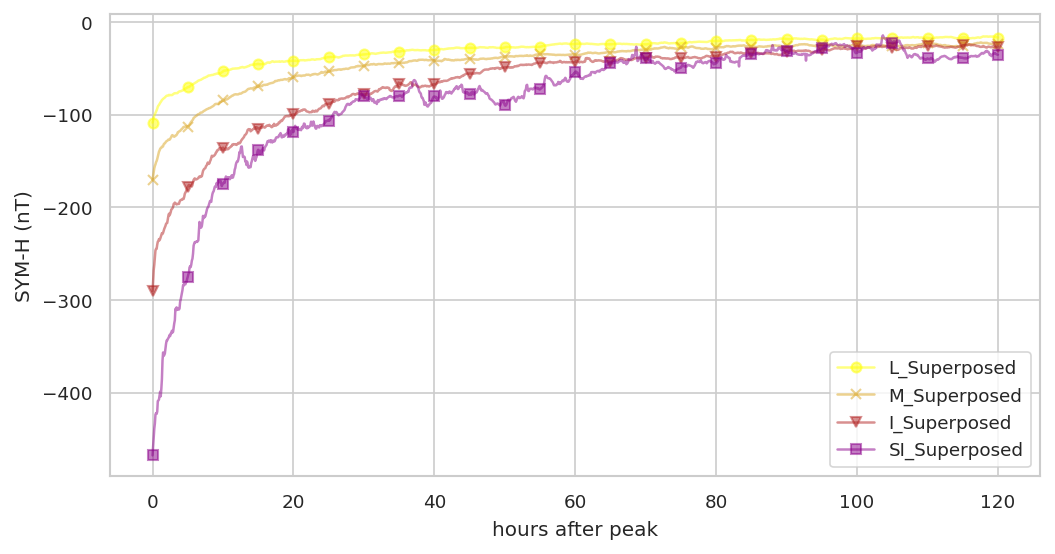

In [11]:
# Define names and indices for different storm classifications
names = ['L_', 'M_', 'I_', 'SI_']
names_long = ['Low_Storms', 'Moderate_Storms', 'Intense_Storms', 'SuperIntense_Storms']
classification = ['Low', 'Moderate', 'Intense', 'SuperIntense']
all_indices = [low_indices, moderate_indices, intense_indices, superintense_indices]

# Create a dataframe for the forward superposed epoch plot
superposed_forward = pd.DataFrame(index=pd.timedelta_range(start='0 days', end=f'{utils.SUPERPOSED_DAYS_AFTER} days', freq='5min'))
superposed_dfs_forward = []

# Define the time offset for the forward superposed epoch plot
delta_forward = pd.DateOffset(days=utils.SUPERPOSED_DAYS_AFTER)

for i in range(len(all_indices)):
    indices = all_indices[i]
    name = names[i]
    superposed_df = pd.DataFrame(index=pd.timedelta_range(start='0 days', end=f'{utils.SUPERPOSED_DAYS_AFTER} days', freq='5min'))
    
    print('Evaluating for indices', name)
    
    dfs_tmp = []
    
    for storm_index in indices:
        # Get data for the current storm
        strm = utils.get_storm(dfx, summary_df_sym, storm_index)        
        strm = strm[['SYM_H']]
        
        # Find the time index of the index peak in 'SYM_H'
        idxmin = strm['SYM_H'].idxmin()
        
        # Rename the columns to include storm index
        strm.columns = [[f'storm-{storm_index}']]
        
        # Extract a time window of data centered around the index peak
        strm = strm[idxmin:idxmin + delta_forward].copy()
        print('Storm', storm_index, strm.index[0], strm.index[-1])
        
        # Create a new index for the data in 5-minute intervals
        strm.index = pd.timedelta_range(start='0 days', freq='5min', periods=len(strm))
        
        dfs_tmp.append(strm)
        
    # Combine data for all storms of the current classification
    superposed_df = pd.concat(dfs_tmp, axis=1)
    
    # Average the storms for the superposed epoch plot
    superposed_df[f'{name}Superposed'] = superposed_df.mean(axis=1)
    
    # Append the superposed data for the current classification to a list
    superposed_dfs_forward.append(superposed_df.copy())
    
    # Add the superposed data to the main superposed dataframe
    superposed_forward[f'{name}Superposed'] = superposed_df[f'{name}Superposed']

# Create a new column in the main dataframe for hours to ease the plotting
superposed_forward['hours'] = superposed_forward.index / pd.Timedelta(hours=1)

# Plot the superposed epoch storms for each class
fig, ax = plt.subplots(1, figsize=utils.global_figsize)
ax = superposed_forward.plot(x='hours', y='L_Superposed', color=utils.COLOR_LOW, marker='o', ax=ax, markevery=5 * 12, alpha=0.5)
ax = superposed_forward.plot(x='hours', y='M_Superposed', color=utils.COLOR_MODERATE, marker='x', ax=ax, markevery=5 * 12, alpha=0.5)
ax = superposed_forward.plot(x='hours', y='I_Superposed', color=utils.COLOR_INTENSE, marker="v", ax=ax, markevery=5 * 12, alpha=0.5)
ax = superposed_forward.plot(x='hours', y='SI_Superposed', color=utils.COLOR_SUPERINTENSE, marker="s", ax=ax, markevery=5 * 12, alpha=0.5, ylabel='SYM-H (nT)', xlabel='hours after peak')
plt.show()


## Backward  <a class="anchor" id="section_2_2"></a>

Evaluating for indices L_
Storm 4 1981-06-24 12:00:00 1981-06-29 12:00:00
Storm 6 1981-08-18 23:10:00 1981-08-23 23:10:00
Storm 9 1982-01-28 09:10:00 1982-02-02 09:10:00
Storm 21 1983-03-20 07:45:00 1983-03-25 07:45:00
Storm 25 1983-11-07 08:45:00 1983-11-12 08:45:00
Storm 26 1983-12-30 08:10:00 1984-01-04 08:10:00
Storm 27 1984-01-30 21:40:00 1984-02-04 21:40:00
Storm 28 1984-03-23 21:25:00 1984-03-28 21:25:00
Storm 29 1984-04-21 04:40:00 1984-04-26 04:40:00
Storm 30 1984-05-16 08:45:00 1984-05-21 08:45:00
Storm 31 1984-07-08 13:35:00 1984-07-13 13:35:00
Storm 34 1984-09-18 14:50:00 1984-09-23 14:50:00
Storm 38 1985-02-23 06:30:00 1985-02-28 06:30:00
Storm 42 1986-05-01 17:35:00 1986-05-06 17:35:00
Storm 44 1986-10-08 20:45:00 1986-10-13 20:45:00
Storm 45 1986-10-30 18:35:00 1986-11-04 18:35:00
Storm 46 1986-11-20 18:20:00 1986-11-25 18:20:00
Storm 47 1987-07-24 09:00:00 1987-07-29 09:00:00
Storm 48 1987-08-20 18:10:00 1987-08-25 18:10:00
Storm 49 1987-12-28 20:30:00 1988-01-02 20:30:

/tmp/ipykernel_45033/549177588.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  superposed_df[f'{name}Superposed'] = superposed_df.mean(axis = 1)


Storm 39 1985-04-16 08:20:00 1985-04-21 08:20:00
Storm 40 1985-11-25 01:30:00 1985-11-30 01:30:00
Storm 43 1986-09-07 04:55:00 1986-09-12 04:55:00
Storm 50 1988-01-10 04:05:00 1988-01-15 04:05:00
Storm 51 1988-02-17 16:30:00 1988-02-22 16:30:00
Storm 52 1988-03-21 22:00:00 1988-03-26 22:00:00
Storm 54 1988-05-01 10:50:00 1988-05-06 10:50:00
Storm 56 1988-10-05 12:50:00 1988-10-10 12:50:00
Storm 59 1989-01-06 19:10:00 1989-01-11 19:10:00
Storm 62 1989-04-21 05:50:00 1989-04-26 05:50:00
Storm 64 1989-06-05 15:50:00 1989-06-10 15:50:00
Storm 65 1989-08-24 04:40:00 1989-08-29 04:40:00
Storm 72 1990-03-25 11:25:00 1990-03-30 11:25:00
Storm 75 1990-06-08 03:20:00 1990-06-13 03:20:00
Storm 76 1990-07-24 07:35:00 1990-07-29 07:35:00
Storm 78 1990-10-05 08:15:00 1990-10-10 08:15:00
Storm 79 1990-11-22 21:10:00 1990-11-27 21:10:00
Storm 83 1991-05-31 16:55:00 1991-06-05 16:55:00
Storm 85 1991-08-14 08:05:00 1991-08-19 08:05:00
Storm 87 1991-09-26 23:10:00 1991-10-01 23:10:00
Storm 90 1992-02-04 

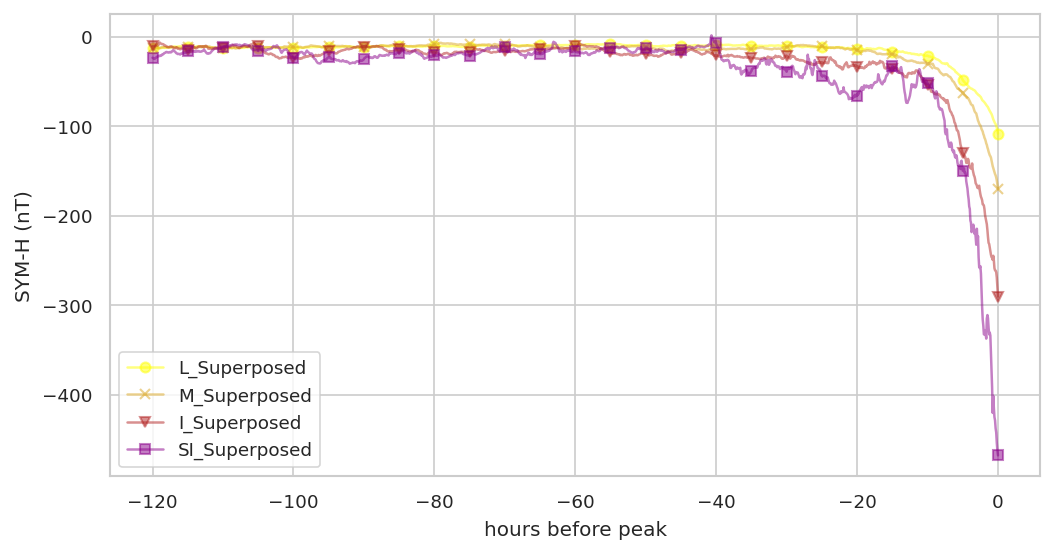

In [12]:
# Create a dataframe for the backward superposed epoch plot
superposed_backward = pd.DataFrame(index=pd.timedelta_range(start=f'-{utils.SUPERPOSED_DAYS_BEFORE} days', end='0 days', freq='5min'))
superposed_dfs_backward = []

# Define the time offset for the backward superposed epoch plot
delta_backward = pd.DateOffset(days=utils.SUPERPOSED_DAYS_BEFORE)

for i in range(len(all_indices)):
    indices = all_indices[i]
    name = names[i]
    superposed_df = pd.DataFrame(index=pd.timedelta_range(start=f'-{utils.SUPERPOSED_DAYS_BEFORE} days', end='0 days', freq='5min'))
    
    print('Evaluating for indices', name)
    
    dfs_tmp = []
    
    for storm_index in indices:
        # Get data for the current storm
        strm = utils.get_storm(dfx, summary_df_sym, storm_index)        
        strm = strm[['SYM_H']]
        
        # Find the time index of the SYM_H peak
        idxmin = strm['SYM_H'].idxmin()
        
        # Rename the columns to include storm index
        strm.columns = [[f'storm-{storm_index}']]
        
        # Extract a time window of data before the index peak
        strm = strm[idxmin - delta_backward: idxmin].copy()
        print('Storm', storm_index, strm.index[0], strm.index[-1])
        
        # Create a new index for the data in 5-minute intervals
        strm.index = pd.timedelta_range(start=f'-{utils.SUPERPOSED_DAYS_AFTER} days', freq='5min', periods=len(strm))
        dfs_tmp.append(strm)
        
    # Combine data for all storms of the current classification
    superposed_df = pd.concat(dfs_tmp, axis=1)
    
    # Average the storms for the superposed epoch plot
    superposed_df[f'{name}Superposed'] = superposed_df.mean(axis=1)    
    superposed_dfs_backward.append(superposed_df.copy())
    
    # Add the superposed data to the main superposed dataframe
    superposed_backward[f'{name}Superposed'] = superposed_df[f'{name}Superposed']

# Create a new column in the main dataframe for hours to ease the plotting
superposed_backward['hours'] = superposed_backward.index / pd.Timedelta(hours=1)

# Plot the superposed epoch storms for each class
fig, ax = plt.subplots(1, figsize=utils.global_figsize)
ax = superposed_backward.plot(x='hours', y='L_Superposed', color=utils.COLOR_LOW, marker='o', ax=ax, markevery=5 * 12, alpha=0.5)
ax = superposed_backward.plot(x='hours', y='M_Superposed', color=utils.COLOR_MODERATE, marker='x', ax=ax, markevery=5 * 12, alpha=0.5)
ax = superposed_backward.plot(x='hours', y='I_Superposed', color=utils.COLOR_INTENSE, marker="v", ax=ax, markevery=5 * 12, alpha=0.5)
ax = superposed_backward.plot(x='hours', y='SI_Superposed', color=utils.COLOR_SUPERINTENSE, marker="s", ax=ax, markevery=5 * 12, alpha=0.5, ylabel='SYM-H (nT)', xlabel='hours before peak')
plt.show()


## Both directions  <a class="anchor" id="section_2_3"></a>

In [13]:
# Create a dataframe for the superposed epoch plot in both directions
superposed_total = pd.DataFrame(index=pd.timedelta_range(start=f'-{utils.SUPERPOSED_DAYS_BEFORE} days', end=f'{utils.SUPERPOSED_DAYS_AFTER} days', freq='5min'))
superposed_dfs_total = []

# Columns for the .csv with the dates used for the superposed epoch plot
sum_cols = ["Start date", "End date", "Min SYM-H", "Classification"]
dates_superposed = pd.DataFrame(columns=sum_cols)

for i in range(len(all_indices)):
    indices = all_indices[i]
    name = names[i]
    superposed_df = pd.DataFrame(index=pd.timedelta_range(start=f'-{utils.SUPERPOSED_DAYS_BEFORE} days', end=f'{utils.SUPERPOSED_DAYS_AFTER} days', freq='5min'))

    print('Evaluating for indices', name)

    dfs_tmp = []

    for storm_index in indices:
        # Get data for the current storm
        strm = utils.get_storm(dfx, summary_df_sym, storm_index)
        strm = strm[['SYM_H']]
        idxmin = strm['SYM_H'].idxmin()

        # Create a dataframe with storm information for later on saving the dates to a .csv file
        dates_superposed = pd.concat([dates_superposed,
                                      pd.DataFrame(
                                          data=[[idxmin - delta_backward,
                                                 idxmin + delta_forward,
                                                 strm['SYM_H'].min(),
                                                 classification[i]]],
                                          columns=sum_cols)],
                                     ignore_index=True)

        strm.columns = [[f'storm-{storm_index}']]
        strm = strm[idxmin - delta_backward: idxmin + delta_forward].copy()
        print('Storm', storm_index, strm.index[0], strm.index[-1])

        # Create a new index for the data in 5-minute intervals
        strm.index = pd.timedelta_range(start=f'-{utils.SUPERPOSED_DAYS_BEFORE} days', freq='5min', periods=len(strm))
        dfs_tmp.append(strm)

        superposed_df = pd.concat(dfs_tmp, axis=1)

    # Average the storms for the superposed epoch plot
    superposed_df[f'{name}Superposed'] = superposed_df.mean(axis=1)
    superposed_dfs_total.append(superposed_df.copy())

    superposed_total[f'{name}Superposed'] = superposed_df[f'{name}Superposed']

# Create a new column in the main dataframe for hours to ease the plotting
superposed_total['hours'] = superposed_total.index / pd.Timedelta(hours=1)


Evaluating for indices L_
Storm 4 1981-06-24 12:00:00 1981-07-04 12:00:00
Storm 6 1981-08-18 23:10:00 1981-08-28 23:10:00
Storm 9 1982-01-28 09:10:00 1982-02-07 09:10:00
Storm 21 1983-03-20 07:45:00 1983-03-30 07:45:00
Storm 25 1983-11-07 08:45:00 1983-11-17 08:45:00
Storm 26 1983-12-30 08:10:00 1984-01-09 08:10:00
Storm 27 1984-01-30 21:40:00 1984-02-09 21:40:00
Storm 28 1984-03-23 21:25:00 1984-04-02 21:25:00
Storm 29 1984-04-21 04:40:00 1984-05-01 04:40:00
Storm 30 1984-05-16 08:45:00 1984-05-26 08:45:00
Storm 31 1984-07-08 13:35:00 1984-07-18 13:35:00
Storm 34 1984-09-18 14:50:00 1984-09-28 14:50:00
Storm 38 1985-02-23 06:30:00 1985-03-05 06:30:00
Storm 42 1986-05-01 17:35:00 1986-05-11 17:35:00
Storm 44 1986-10-08 20:45:00 1986-10-18 20:45:00
Storm 45 1986-10-30 18:35:00 1986-11-09 18:35:00
Storm 46 1986-11-20 18:20:00 1986-11-30 18:20:00
Storm 47 1987-07-24 09:00:00 1987-08-03 09:00:00
Storm 48 1987-08-20 18:10:00 1987-08-30 18:10:00
Storm 49 1987-12-28 20:30:00 1988-01-07 20:30:

/tmp/ipykernel_45033/3095341930.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  superposed_df[f'{name}Superposed'] = superposed_df.mean(axis = 1)


Storm 24 1983-08-03 06:35:00 1983-08-13 06:35:00
Storm 32 1984-07-27 06:50:00 1984-08-06 06:50:00
Storm 33 1984-08-31 06:50:00 1984-09-10 06:50:00
Storm 36 1984-11-11 07:25:00 1984-11-21 07:25:00
Storm 39 1985-04-16 08:20:00 1985-04-26 08:20:00
Storm 40 1985-11-25 01:30:00 1985-12-05 01:30:00
Storm 43 1986-09-07 04:55:00 1986-09-17 04:55:00
Storm 50 1988-01-10 04:05:00 1988-01-20 04:05:00
Storm 51 1988-02-17 16:30:00 1988-02-27 16:30:00
Storm 52 1988-03-21 22:00:00 1988-03-31 22:00:00
Storm 54 1988-05-01 10:50:00 1988-05-11 10:50:00
Storm 56 1988-10-05 12:50:00 1988-10-15 12:50:00
Storm 59 1989-01-06 19:10:00 1989-01-16 19:10:00
Storm 62 1989-04-21 05:50:00 1989-05-01 05:50:00
Storm 64 1989-06-05 15:50:00 1989-06-15 15:50:00
Storm 65 1989-08-24 04:40:00 1989-09-03 04:40:00
Storm 72 1990-03-25 11:25:00 1990-04-04 11:25:00
Storm 75 1990-06-08 03:20:00 1990-06-18 03:20:00
Storm 76 1990-07-24 07:35:00 1990-08-03 07:35:00
Storm 78 1990-10-05 08:15:00 1990-10-15 08:15:00
Storm 79 1990-11-22 

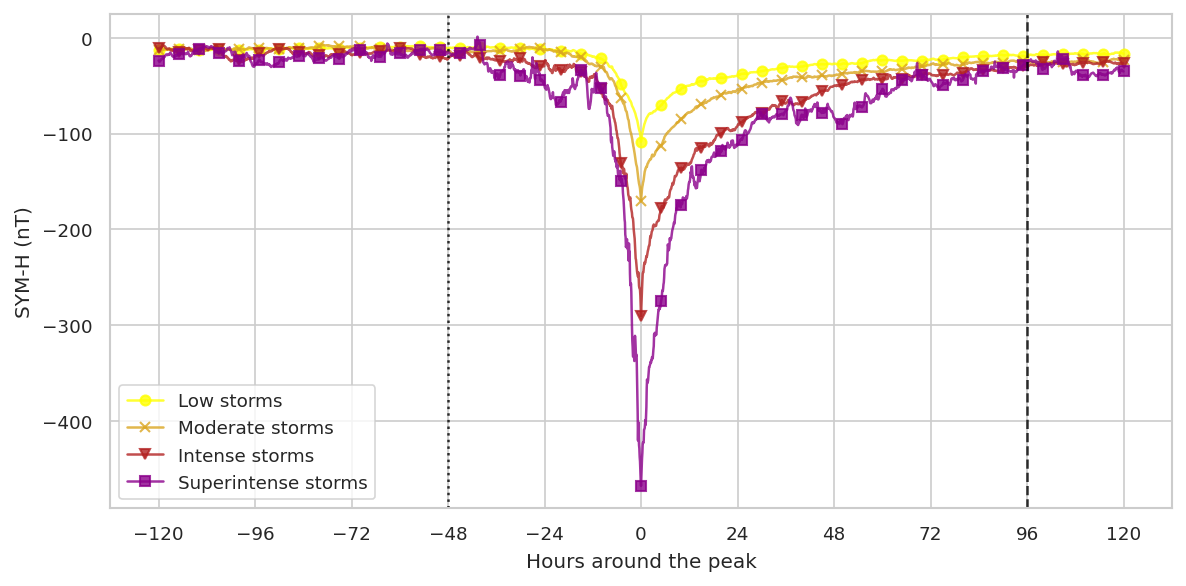

In [14]:
# Plot the superposed epoch plot with vertical lines on the limits for the start and end of the storm
fig, ax = plt.subplots(1, figsize = utils.global_figsize)
ax = superposed_total.plot(x = 'hours', y ='L_Superposed', color = utils.COLOR_LOW, marker = 'o', ax = 
                           ax, markevery = 5 * 12, alpha = 0.8, label = 'Low storms')
ax = superposed_total.plot(x = 'hours', y ='M_Superposed', color = utils.COLOR_MODERATE, marker = 'x', 
                           ax = ax, markevery = 5 * 12, alpha = 0.8, label = 'Moderate storms')
ax = superposed_total.plot(x = 'hours', y ='I_Superposed', color = utils.COLOR_INTENSE, marker = "v", 
                           ax = ax, markevery = 5 * 12, alpha = 0.8, label = 'Intense storms')
ax = superposed_total.plot(x = 'hours', y ='SI_Superposed', color = utils.COLOR_SUPERINTENSE, marker = "s", ax = ax, 
                           markevery = 5 * 12, alpha = 0.8, ylabel = 'SYM-H (nT)', xlabel = 'Hours around the peak', 
                           label = 'Superintense storms')
ax.axvline(x = 24 * 4, linestyle = 'dashed', color = 'black', alpha = 0.8)
ax.axvline(x = -24 * 2, linestyle = 'dotted', color = 'black', alpha = 0.8)
ax.legend(['Low storms', 'Moderate storms', 'Intense storms', 'Superintense storms'])
plt.xticks([-120, -96, -72, -48, -24, 0, 24, 48, 72, 96, 120])
plt.tight_layout();
plt.savefig('figs/sym-superposed.png')
plt.show();

## PELT analysis for identifying changepoints  <a class="anchor" id="section_2_4"></a>

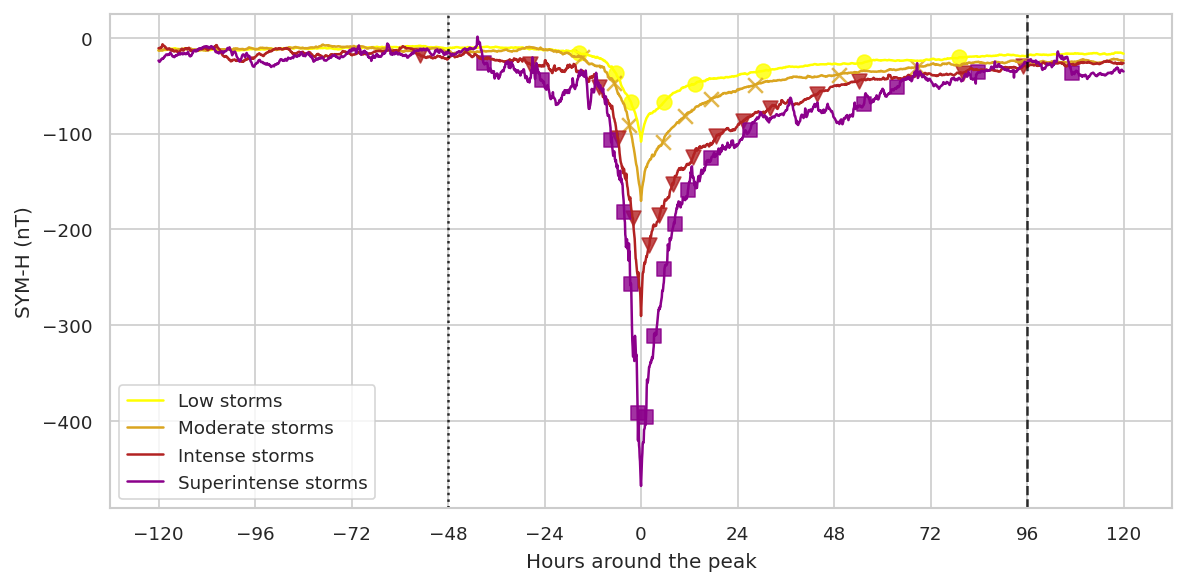

In [15]:
# Define markers, columns to analyze, column names, and colors for plotting
markers = ['o', 'x', 'v', 's']
columns_to_analyze = ['L_Superposed', 'M_Superposed', 'I_Superposed', 'SI_Superposed']
column_names = ['Low storms', 'Moderate storms', 'Intense storms', 'Superintense storms']
colors = [utils.COLOR_LOW, utils.COLOR_MODERATE, utils.COLOR_INTENSE, utils.COLOR_SUPERINTENSE]

plt.figure(figsize=utils.global_figsize)

# Calculate the change points for all the classes in the superposed epoch analysis
for i, col_name in enumerate(columns_to_analyze):
    data = np.array(np.round(superposed_total[col_name].values, 3))
    
    # Perform change point detection using the Pelt Search algorithm
    algo = rpt.Pelt(model="l1", min_size=10, jump=5).fit(data)
    result = algo.predict(pen=500)
    result.pop()
    
    # Plot the original data
    plt.plot(superposed_total['hours'], data, color=colors[i], label=column_names[i])
    
    # Plot markers at change points detected by the algorithm
    plt.scatter(superposed_total.iloc[result]['hours'].values, superposed_total.iloc[result][col_name].values,
                alpha=0.8, color=colors[i], label='_nolegend_', marker=markers[i], s=50)
        
# Add labels, legends, and vertical lines for reference
plt.xlabel('Hours around the peak')
plt.ylabel('SYM-H (nT)')
plt.legend(['Low storms', 'Moderate storms', 'Intense storms', 'Superintense storms'])
plt.xticks([-120, -96, -72, -48, -24, 0, 24, 48, 72, 96, 120])
plt.axvline(x=24 * 4, linestyle='dashed', color='black', alpha=0.8)
plt.axvline(x=-24 * 2, linestyle='dotted', color='black', alpha=0.8)

# Adjust layout, save the figure to a file, and display it
plt.tight_layout()
plt.savefig('figs/sym-superposed-cp.png')
plt.show()

In [16]:
# Save the dates for the superposed epoch plot to a csv file in the format
# Start Date, End Date, Storm duration, Minimum SYM-H, Classification
dates_superposed.to_csv('./data/dates_sym_superposed.csv', index = False)